In [24]:
# 1) Підготовка середовища
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
confusion_matrix, ConfusionMatrixDisplay,
roc_curve, auc, RocCurveDisplay, classification_report)


# Встановіть стиль для графіків
sns.set(style='whitegrid')

In [25]:
# 2) Завантаження даних

df = sns.load_dataset('titanic')


# Ознайомлення з даними
print("Перші 10 рядків:")
print(df.head(10))


print('\nБазова статистика (describe):')
print(df.describe(include='all').T)


print('\nПропущені значення по стовпцях:')
print(df.isnull().sum())

Перші 10 рядків:
   survived  pclass     sex   age  sibsp  parch     fare embarked   class  \
0         0       3    male  22.0      1      0   7.2500        S   Third   
1         1       1  female  38.0      1      0  71.2833        C   First   
2         1       3  female  26.0      0      0   7.9250        S   Third   
3         1       1  female  35.0      1      0  53.1000        S   First   
4         0       3    male  35.0      0      0   8.0500        S   Third   
5         0       3    male   NaN      0      0   8.4583        Q   Third   
6         0       1    male  54.0      0      0  51.8625        S   First   
7         0       3    male   2.0      3      1  21.0750        S   Third   
8         1       3  female  27.0      0      2  11.1333        S   Third   
9         1       2  female  14.0      1      0  30.0708        C  Second   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C  

In [26]:
# 3) Попередня обробка даних

# Копія для безпеки
data = df.copy()

# Заповнення Age середнім
age_mean = data['age'].mean()
data['age'] = data['age'].fillna(age_mean)


# Заповнення embarked (в seaborn це 'embarked') модою
embarked_mode = data['embarked'].mode()[0]
data['embarked'] = data['embarked'].fillna(embarked_mode)


# Додамо FamilySize
data['family_size'] = data['sibsp'].fillna(0) + data['parch'].fillna(0)


# Цільова змінна — 'survived'
# Використаємо такі предиктори: pclass, age, fare, family_size, sex, embarked
features = ['pclass', 'age', 'fare', 'family_size', 'sex', 'embarked']


# Дропнем рядки, де survived відсутній (у вбудованому датасеті зазвичай є)
data = data[features + ['survived']].copy()


# One-hot encoding для sex та embarked
data = pd.get_dummies(data, columns=['sex', 'embarked'], drop_first=True)


print('\nПісля обробки — перші 8 рядків:')
print(data.head(8))


# Перевіримо ще раз на пропуски
print('\nПропуски після обробки:')
print(data.isnull().sum())


Після обробки — перші 8 рядків:
   pclass        age     fare  family_size  survived  sex_male  embarked_Q  \
0       3  22.000000   7.2500            1         0      True       False   
1       1  38.000000  71.2833            1         1     False       False   
2       3  26.000000   7.9250            0         1     False       False   
3       1  35.000000  53.1000            1         1     False       False   
4       3  35.000000   8.0500            0         0      True       False   
5       3  29.699118   8.4583            0         0      True        True   
6       1  54.000000  51.8625            0         0      True       False   
7       3   2.000000  21.0750            4         0      True       False   

   embarked_S  
0        True  
1       False  
2        True  
3        True  
4        True  
5       False  
6        True  
7        True  

Пропуски після обробки:
pclass         0
age            0
fare           0
family_size    0
survived       0
sex_male  

In [27]:
# 4) Поділ на тренувальну та тестову вибірки (80/20)
X = data.drop(columns=['survived'])
y = data['survived']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)


print(f"\nРозміри: X_train={X_train.shape}, X_test={X_test.shape}")


Розміри: X_train=(712, 7), X_test=(179, 7)


In [28]:
# 5) Побудова моделей
def evaluate_model(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
# деякі моделі можуть не мати predict_proba
        y_prob = None


    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)


    print(f"\n--- Оцінка моделі: {model_name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print('\nClassification report:')
    print(classification_report(y_test, y_pred, digits=4))


    # Матриця плутанини
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix — {model_name}')
    plt.show()


# ROC та AUC
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, lw=2)
        plt.plot([0, 1], [0, 1], linestyle='--', lw=1)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC curve (AUC = {roc_auc:.4f}) — {model_name}')
        plt.show()
    else:
        print('predict_proba недоступний — ROC/AUC не побудовано')


    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}


--- Оцінка моделі: Logistic Regression ---
Accuracy: 0.7933
Precision: 0.7667
Recall: 0.6667
F1-score: 0.7132

Classification report:
              precision    recall  f1-score   support

           0     0.8067    0.8727    0.8384       110
           1     0.7667    0.6667    0.7132        69

    accuracy                         0.7933       179
   macro avg     0.7867    0.7697    0.7758       179
weighted avg     0.7913    0.7933    0.7901       179



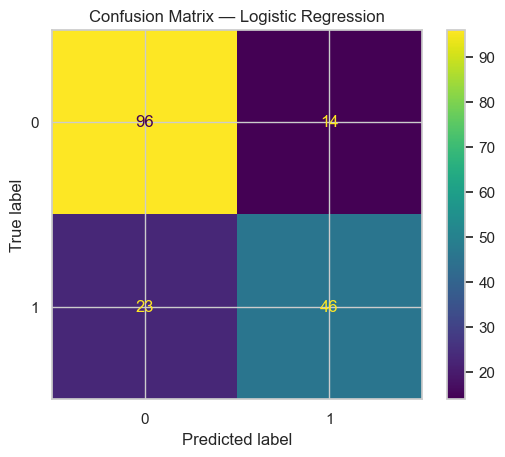

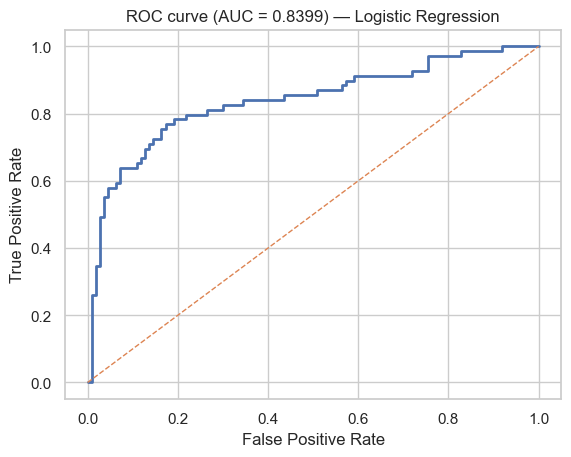


--- Оцінка моделі: Decision Tree ---
Accuracy: 0.7989
Precision: 0.7324
Recall: 0.7536
F1-score: 0.7429

Classification report:
              precision    recall  f1-score   support

           0     0.8426    0.8273    0.8349       110
           1     0.7324    0.7536    0.7429        69

    accuracy                         0.7989       179
   macro avg     0.7875    0.7904    0.7889       179
weighted avg     0.8001    0.7989    0.7994       179



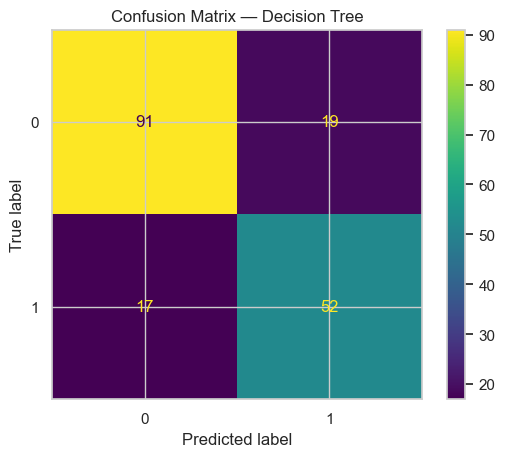

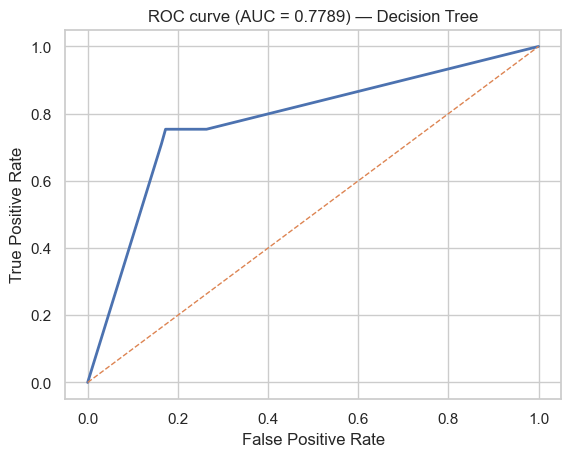

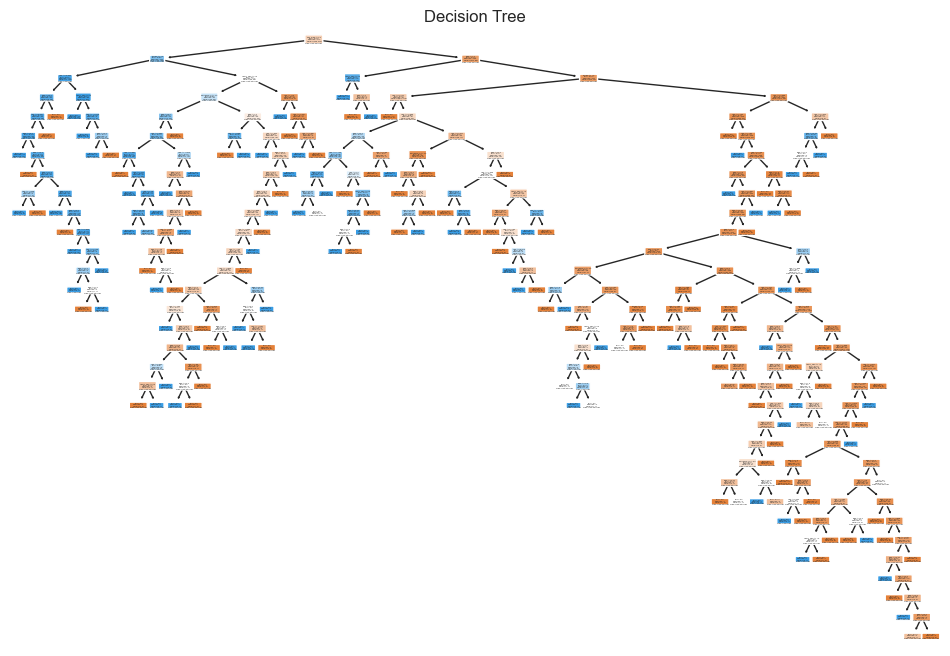


--- Оцінка моделі: Random Forest ---
Accuracy: 0.8101
Precision: 0.7869
Recall: 0.6957
F1-score: 0.7385

Classification report:
              precision    recall  f1-score   support

           0     0.8220    0.8818    0.8509       110
           1     0.7869    0.6957    0.7385        69

    accuracy                         0.8101       179
   macro avg     0.8045    0.7887    0.7947       179
weighted avg     0.8085    0.8101    0.8075       179



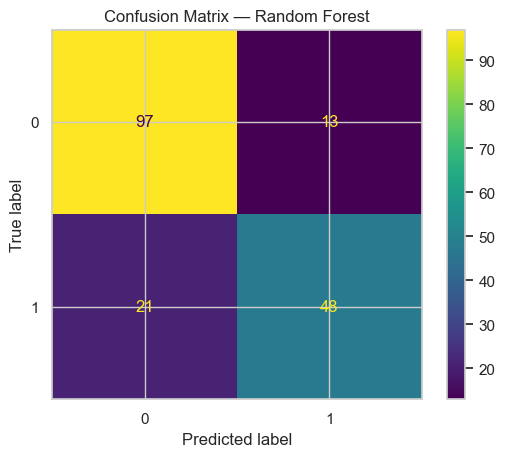

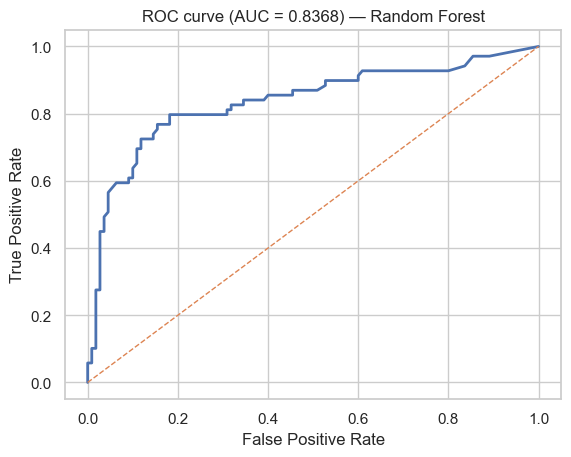

In [29]:
# 5.1 Логістична регресія

logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train, y_train)
eval_logreg = evaluate_model(logreg, X_test, y_test, model_name='Logistic Regression')


# 5.2 Дерево рішень
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
eval_dt = evaluate_model(dt, X_test, y_test, model_name='Decision Tree')


# Додатково: візуалізація дерева (за потреби — можна зберегти велике полотно)
plt.figure(figsize=(12,8))
plot_tree(dt, feature_names=X.columns, class_names=['Not survived','Survived'], filled=True, rounded=True)
plt.title('Decision Tree')
plt.show()


# 5.3 Випадковий ліс
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
eval_rf = evaluate_model(rf, X_test, y_test, model_name='Random Forest')

In [30]:
# 6) Крос-валідація (Logistic Regression та Decision Tree)
print('\nКрос-валідація (5-fold) — Logistic Regression')
cv_log = cross_val_score(logreg, X, y, cv=5, scoring='accuracy')
print('CV accuracy scores:', cv_log)
print('CV accuracy mean:', cv_log.mean())


print('\nКрос-валідація (5-fold) — Decision Tree')
cv_dt = cross_val_score(dt, X, y, cv=5, scoring='accuracy')
print('CV accuracy scores:', cv_dt)
print('CV accuracy mean:', cv_dt.mean())


Крос-валідація (5-fold) — Logistic Regression
CV accuracy scores: [0.77094972 0.79213483 0.79213483 0.78089888 0.8258427 ]
CV accuracy mean: 0.7923921913250895

Крос-валідація (5-fold) — Decision Tree
CV accuracy scores: [0.74860335 0.76966292 0.79213483 0.75280899 0.79213483]
CV accuracy mean: 0.771068984997803



Найкращі параметри для Random Forest (GridSearchCV):
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

--- Оцінка моделі: Random Forest (GridSearchCV best) ---
Accuracy: 0.7989
Precision: 0.8000
Recall: 0.6377
F1-score: 0.7097

Classification report:
              precision    recall  f1-score   support

           0     0.7984    0.9000    0.8462       110
           1     0.8000    0.6377    0.7097        69

    accuracy                         0.7989       179
   macro avg     0.7992    0.7688    0.7779       179
weighted avg     0.7990    0.7989    0.7935       179



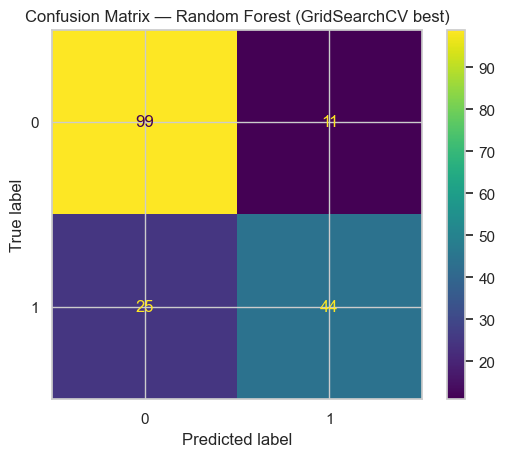

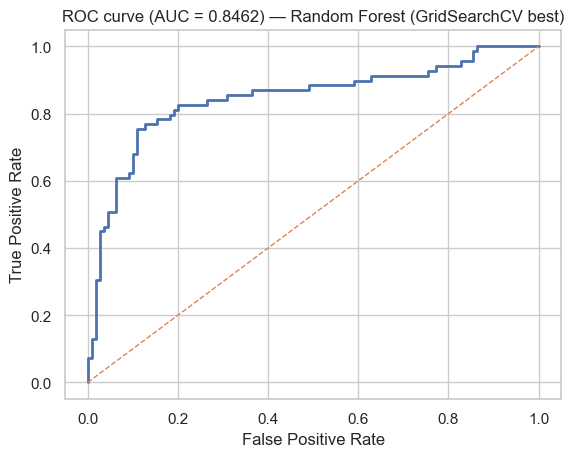

In [31]:
# 7) Гіперпараметричний пошук для Random Forest (GridSearchCV)
param_grid = {
'n_estimators': [50, 100, 200],
'max_depth': [None, 5, 10],
'min_samples_split': [2, 5, 10]
}


grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='f1')
grid_rf.fit(X_train, y_train)


print('\nНайкращі параметри для Random Forest (GridSearchCV):')
print(grid_rf.best_params_)


best_rf = grid_rf.best_estimator_
eval_best_rf = evaluate_model(best_rf, X_test, y_test, model_name='Random Forest (GridSearchCV best)')


Порівняння моделей:
                         accuracy  precision    recall        f1
Logistic Regression      0.793296   0.766667  0.666667  0.713178
Decision Tree            0.798883   0.732394  0.753623  0.742857
Random Forest (default)  0.810056   0.786885  0.695652  0.738462
Random Forest (best)     0.798883   0.800000  0.637681  0.709677


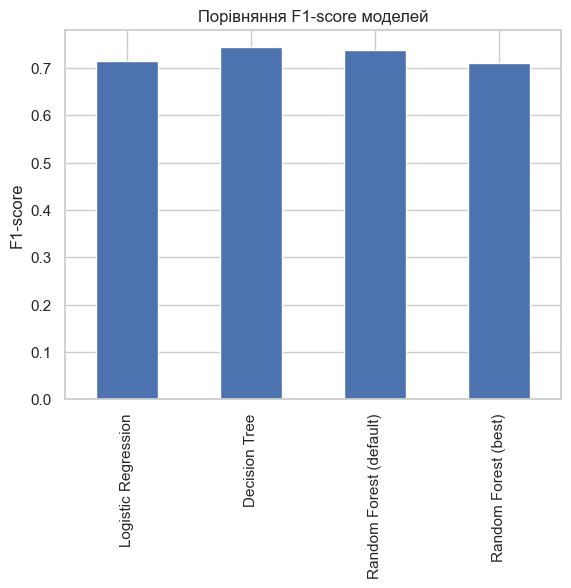

In [32]:
# 8) Порівняння моделей — збір метрик у таблиці
results = pd.DataFrame([eval_logreg, eval_dt, eval_rf, eval_best_rf],
index=['Logistic Regression', 'Decision Tree', 'Random Forest (default)', 'Random Forest (best)'])


print('\nПорівняння моделей:')
print(results)


# Візуалізація порівняння F1-score
results['f1'].plot(kind='bar', title='Порівняння F1-score моделей')
plt.ylabel('F1-score')
plt.show()


Важливість ознак (Random Forest):
sex_male       0.327390
fare           0.244301
age            0.204864
pclass         0.106622
family_size    0.077559
embarked_S     0.027580
embarked_Q     0.011685
dtype: float64


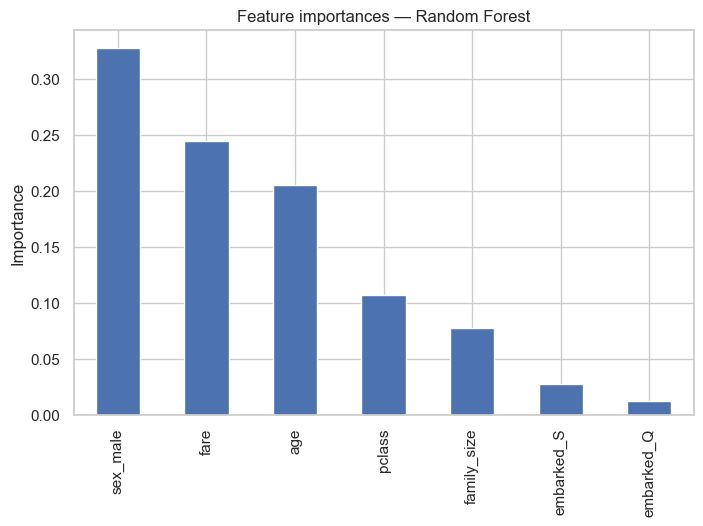

In [33]:
# 9) Важливість ознак для Random Forest
importances = best_rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print('\nВажливість ознак (Random Forest):')
print(feat_imp)


plt.figure(figsize=(8,5))
feat_imp.plot(kind='bar')
plt.title('Feature importances — Random Forest')
plt.ylabel('Importance')
plt.show()